In [ ]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
import scipy.stats as ss
from scipy.stats import norm
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from collections import Counter
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, ConfusionMatrixDisplay

1. Моделирование ОВ1 и ОВ2

In [ ]:
#Создание обучающих выборок
p=3
mu1=np.array([0.,0.,0.])
sigma1=np.array([[1,0,0],
                 [0,1,0],
                 [0,0,1]])
n1=200

mu2=np.array([1.,0.,0.])
sigma2=np.array([[1,0,0],
                 [0,1,0],
                 [0,0,1]])
n2=200

x_train1 = ss.multivariate_normal.rvs(size=n1, mean=mu1, cov=sigma1, random_state=1)
x_train2 = ss.multivariate_normal.rvs(size=n2, mean=mu2, cov=sigma2, random_state=1)

q1 = n1 / (n1 + n2)
q2 = n2 / (n1 + n2)

2. Моделирование ТВ

In [ ]:
#Создание тестовой выборки
n=100
x_test1 = ss.multivariate_normal.rvs(size=n, mean=mu1, cov=sigma1, random_state=1)
x_test2 = ss.multivariate_normal.rvs(size=n, mean=mu2, cov=sigma2, random_state=1)
x_test = np.vstack([x_test1,x_test2])

test_labels = np.array([1]*n + [2]*n)

3. Вычисление выборочных характеристик ОВ1 и ОВ2 и построение классификатора

In [ ]:
#Выборочные характеристики
mu_tr_1 = x_train1.mean(axis=0)
mu_tr_2 = x_train2.mean(axis=0)

s_tr_1 = np.cov(x_train1.T)
s_tr_2 = np.cov(x_train2.T)

print(f'Выборочное среднее ОВ1: {mu_tr_1}')
print(f'Выборочное среднее ОВ2: {mu_tr_2}')
print(f'Ков матрица ОВ1: {s_tr_1}')
print(f'Ков матрица ОВ2: {s_tr_2}')

Выборочное среднее ОВ1: [-0.00070443  0.1131362   0.08395541]
Выборочное среднее ОВ2: [0.99929557 0.1131362  0.08395541]
Ков матрица ОВ1: [[ 0.95134374 -0.08392728  0.07373797]
 [-0.08392728  1.09915179  0.00902446]
 [ 0.07373797  0.00902446  0.94557663]]
Ков матрица ОВ2: [[ 0.95134374 -0.08392728  0.07373797]
 [-0.08392728  1.09915179  0.00902446]
 [ 0.07373797  0.00902446  0.94557663]]


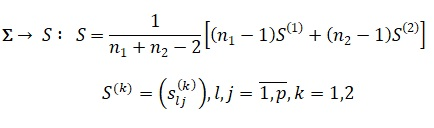

In [ ]:
s = 1 / (n1 + n2 - 2)*((n1 - 1)*s_tr_1 + (n2 - 1)*s_tr_2)
s

array([[ 0.95134374, -0.08392728,  0.07373797],
       [-0.08392728,  1.09915179,  0.00902446],
       [ 0.07373797,  0.00902446,  0.94557663]])

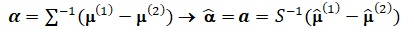

In [ ]:
a = np.linalg.inv(s) @ (mu_tr_1 - mu_tr_2)
a

array([-1.06487576, -0.08199831,  0.08382373])

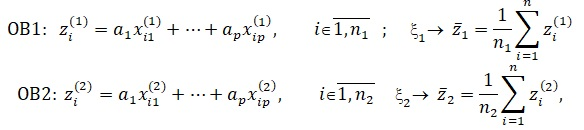

In [ ]:
z1 = (x_train1 @ a).mean()
z2 = (x_train2 @ a).mean()
z1, z2

(-0.0014893876253363868, -1.0663651435986623)

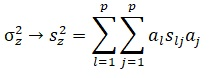

In [ ]:
s_z = a @ s @ a
s_z

1.0648757559733262

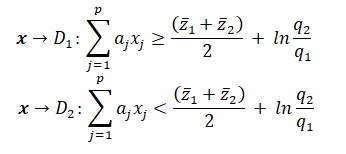

In [ ]:
c = (z1 + z2) / 2 + np.log(q2/q1)

In [ ]:
def predict(x: np.array):
    mask = (x @ a) < c
    labels = np.array([1] * len(x))
    labels[mask] = 2
    return labels

In [ ]:
(predict(x_train1) == 1).sum()

139

In [ ]:
(predict(x_train1) == 2).sum()

61

In [ ]:
(predict(x_train2) == 1).sum()

61

In [ ]:
(predict(x_train2) == 2).sum()

139

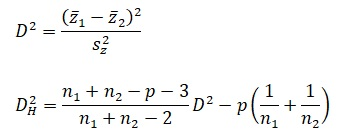

In [ ]:
d2 =  (z1 - z2)**2 / s_z
d2_h = (n1 + n2 - p - 3) / (n1 + n2 - 2) * d2 - p * (1/n1 + 1/n2)
d2, d2_h

(1.0648757559733257, 1.024173487069071)

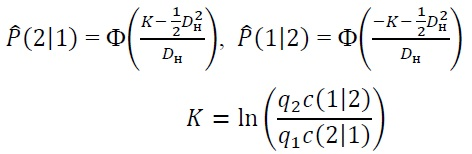

In [ ]:
p_21 = ss.norm.cdf((np.log(q2/q1) - d2_h/2) / np.sqrt(d2_h))
p_21

0.3064257680154203

In [ ]:
p_12 = ss.norm.cdf((-np.log(q2/q1) - d2_h/2) / np.sqrt(d2_h))
p_12

0.3064257680154203

In [ ]:
q1 * p_21 + q2 * p_12

0.3064257680154203

In [ ]:
q1 * (n1 - (predict(x_train1) == 1).sum())/n1 + q2 * (n2 - (predict(x_train2) == 2).sum())/n2

0.305

In [ ]:
test_pred_labels = predict(x_test)

Counter(test_pred_labels)

Counter({2: 98, 1: 102})

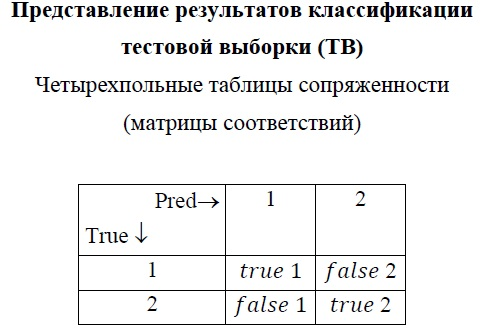

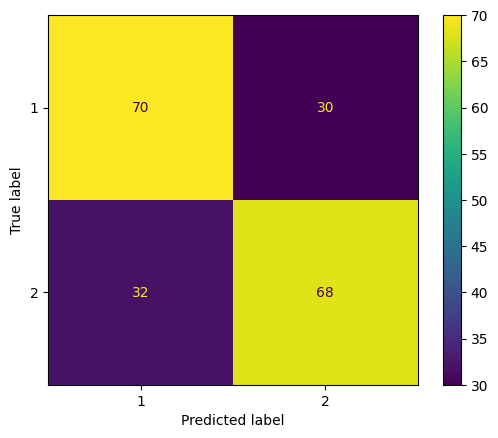

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix(test_labels, test_pred_labels), display_labels=[1, 2])

disp.plot()
plt.show()

In [ ]:
accuracy_score(test_labels, test_pred_labels)

0.69

In [ ]:
dataset = pd.DataFrame(x_test)
dataset.columns = ['X1','X2','X3']
dataset['y'] = test_labels

dataset.info()

#Проверка как выглядят данные (первые 5)
print('Матрица признаков\n', x_test[:5])
print('Вектор целей\n', test_labels[:5])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X1      200 non-null    float64
 1   X2      200 non-null    float64
 2   X3      200 non-null    float64
 3   y       200 non-null    int64  
dtypes: float64(3), int64(1)
memory usage: 6.4 KB
Матрица признаков
 [[ 1.62434536 -0.61175641 -0.52817175]
 [-1.07296862  0.86540763 -2.3015387 ]
 [ 1.74481176 -0.7612069   0.3190391 ]
 [-0.24937038  1.46210794 -2.06014071]
 [-0.3224172  -0.38405435  1.13376944]]
Вектор целей
 [1 1 1 1 1]


In [ ]:
dataset['y'].value_counts()

1    100
2    100
Name: y, dtype: int64

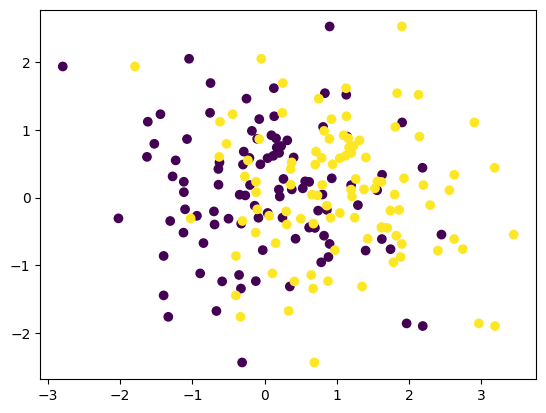

In [ ]:
plt.scatter(x_test[:,0], x_test[:,1], c=test_labels)
plt. show ()

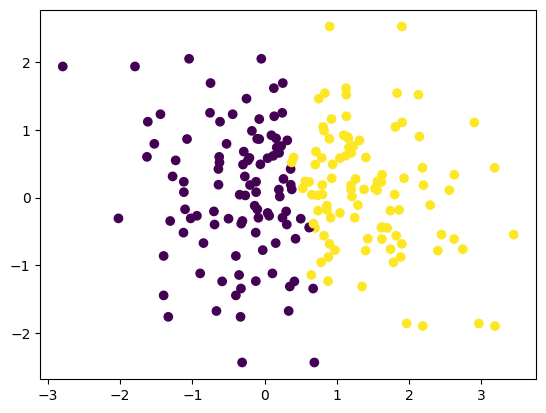

In [ ]:
plt.scatter(x_test[:,0], x_test[:,1], c=test_pred_labels)
plt. show ()